## Context
This notebook will help me gain some experience in using machine learning / data analysis tools whilst on a topic that I enjoy. Taking data from MyAnimeList, https://www.kaggle.com/datasets/azathoth42/myanimelist?select=users_cleaned.csv I will:

- Perform some exploratoy data anaylsis EDA - see if I find anything interesting.
- Using collaborative filtering as a first iteration to recommend anime shows.
- Dive into more advanced techniques such as single value decomp 

In [1]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import defaultdict
import numpy as np
import scipy
from scipy.sparse.linalg import svds
import surprise as sp
import time
print("Setup Complete")

Setup Complete


In [2]:
UsersDF = pd.read_csv('./data/full/users_cleaned.csv')
AnimesDF = pd.read_csv('./data/full/anime_cleaned.csv')
ScoresDF = pd.read_csv('./data/full/animelists_cleaned.csv')

In [3]:
AnimesDF.head()

,anime_id,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,...,broadcast,related,producer,licensor,studio,genre,opening_theme,ending_theme,duration_min,aired_from_year
0,11013,Inu x Boku SS,Inu X Boku Secret Service,妖狐×僕SS,Youko x Boku SS,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,12,Finished Airing,...,Fridays at Unknown,"{'Adaptation': [{'mal_id': 17207, 'type': 'man...","Aniplex, Square Enix, Mainichi Broadcasting Sy...",Sentai Filmworks,David Production,"Comedy, Supernatural, Romance, Shounen","['""Nirvana"" by MUCC']","['#1: ""Nirvana"" by MUCC (eps 1, 11-12)', '#2: ...",24.0,2012.0
1,2104,Seto no Hanayome,My Bride is a Mermaid,瀬戸の花嫁,The Inland Sea Bride,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,26,Finished Airing,...,Unknown,"{'Adaptation': [{'mal_id': 759, 'type': 'manga...","TV Tokyo, AIC, Square Enix, Sotsu",Funimation,Gonzo,"Comedy, Parody, Romance, School, Shounen","['""Romantic summer"" by SUN&LUNAR']","['#1: ""Ashita e no Hikari (明日への光)"" by Asuka Hi...",24.0,2007.0
2,5262,Shugo Chara!! Doki,Shugo Chara!! Doki,しゅごキャラ！！どきっ,"Shugo Chara Ninenme, Shugo Chara! Second Year",https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,51,Finished Airing,...,Unknown,"{'Adaptation': [{'mal_id': 101, 'type': 'manga...","TV Tokyo, Sotsu",NaN,Satelight,"Comedy, Magic, School, Shoujo","['#1: ""Minna no Tamago (みんなのたまご)"" by Shugo Cha...","['#1: ""Rottara Rottara (ロッタラ ロッタラ)"" by Buono! ...",24.0,2008.0
3,721,Princess Tutu,Princess Tutu,プリンセスチュチュ,NaN,https://myanimelist.cdn-dena.com/images/anime/...,TV,Original,38,Finished Airing,...,Fridays at Unknown,"{'Adaptation': [{'mal_id': 1581, 'type': 'mang...","Memory-Tech, GANSIS, Marvelous AQL",ADV Films,Hal Film Maker,"Comedy, Drama, Magic, Romance, Fantasy","['""Morning Grace"" by Ritsuko Okazaki']","['""Watashi No Ai Wa Chiisaikeredo"" by Ritsuko ...",16.0,2002.0
4,12365,Bakuman. 3rd Season,Bakuman.,バクマン。,Bakuman Season 3,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,25,Finished Airing,...,Unknown,"{'Adaptation': [{'mal_id': 9711, 'type': 'mang...","NHK, Shueisha",NaN,J.C.Staff,"Comedy, Drama, Romance, Shounen","['#1: ""Moshimo no Hanashi (もしもの話)"" by nano.RIP...","['#1: ""Pride on Everyday"" by Sphere (eps 1-13)...",24.0,2012.0


Using this to get a count of values https://towardsdatascience.com/dealing-with-list-values-in-pandas-dataframes-a177e534f173

Text(0.5, 1.0, 'Anime Genre')

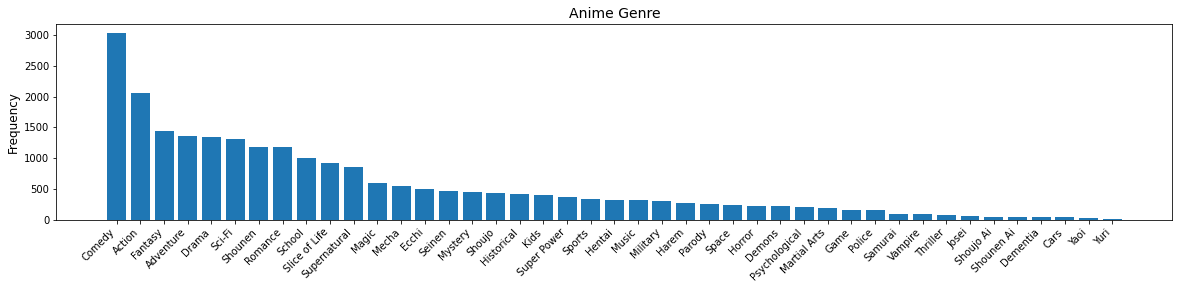

In [4]:
def turn_string_into_list(list_):
    return [x.strip() for x in list_.split(',')]

def to_1D(series):
 return pd.Series([x for _list in series for x in _list])

AnimesDF_without_na_genre = AnimesDF['genre'].dropna()
flattened = AnimesDF_without_na_genre.apply(turn_string_into_list)


fig, ax = plt.subplots(figsize = (20,4))
ax.bar(to_1D(flattened).value_counts().index,
        to_1D(flattened).value_counts().values)
fig.autofmt_xdate(rotation=45)
ax.set_ylabel("Frequency", size = 12)
ax.set_title("Anime Genre", size = 14)

In [5]:
to_1D(flattened).value_counts()

Comedy           3021
Action           2051
Fantasy          1441
Adventure        1355
Drama            1338
Sci-Fi           1318
Shounen          1182
Romance          1177
School           1004
Slice of Life     927
Supernatural      860
Magic             604
Mecha             543
Ecchi             506
Seinen            470
Mystery           454
Shoujo            440
Historical        425
Kids              406
Super Power       367
Sports            338
Hentai            331
Music             329
Military          312
Harem             276
Parody            267
Space             247
Horror            227
Demons            223
Psychological     206
Martial Arts      193
Game              168
Police            155
Samurai           102
Vampire           100
Thriller           79
Josei              67
Shoujo Ai          56
Shounen Ai         55
Dementia           47
Cars               41
Yaoi               28
Yuri               10
dtype: int64

What about correlation between the genres?

In [6]:
flattened_expanded = flattened.apply(pd.Series)

In [7]:
keys = to_1D(flattened).value_counts().keys()
def boolean_df(genres_lists, unique_genres):
# Create empty dict
    bool_dict = {}
    # Loop through all the genres
    for i, item in enumerate(unique_genres):
        # Apply boolean mask
        bool_dict[item] = genres_lists.apply(lambda x: item in x)            
    # Return the results as a dataframe
    return pd.DataFrame(bool_dict)

bool_df = boolean_df(flattened, keys)

bool_corr = bool_df.corr(method="pearson")

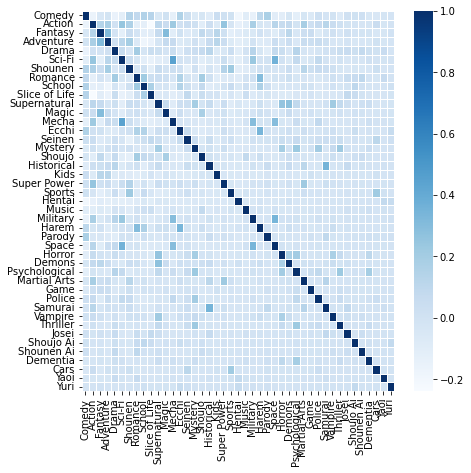

In [8]:
fig, ax = plt.subplots(figsize = (7,7))
sns.heatmap(bool_corr, cmap = "Blues", linewidths=1, xticklabels=True, yticklabels=True)
plt.xticks(rotation=90)
plt.show()

## Recommender

In [9]:
ScoresDF.head(10)

,username,anime_id,my_watched_episodes,my_start_date,my_finish_date,my_score,my_status,my_rewatching,my_rewatching_ep,my_last_updated,my_tags
0,karthiga,21,586,0000-00-00,0000-00-00,9,1,NaN,0,2013-03-03 10:52:53,NaN
1,karthiga,59,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-03-10 13:54:51,NaN
2,karthiga,74,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-04-27 16:43:35,NaN
3,karthiga,120,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-03-03 10:53:57,NaN
4,karthiga,178,26,0000-00-00,0000-00-00,7,2,0.0,0,2013-03-27 15:59:13,NaN
5,karthiga,210,161,0000-00-00,0000-00-00,7,2,NaN,0,2013-03-10 13:57:06,NaN
6,karthiga,232,70,0000-00-00,0000-00-00,6,2,NaN,0,2013-03-09 17:24:42,NaN
7,karthiga,233,78,0000-00-00,0000-00-00,6,2,NaN,0,2013-03-10 05:29:44,NaN
8,karthiga,249,167,0000-00-00,0000-00-00,8,2,NaN,0,2013-03-19 16:04:46,NaN
9,karthiga,269,366,0000-00-00,0000-00-00,10,2,NaN,0,2013-03-03 09:39:23,NaN


Let's keep it simple and extract the columns that I need. (The ScoresDF is a pretty big dataset)

In [10]:
ScoresDF_lite = ScoresDF[['username', 'anime_id', 'my_score', 'my_status']]
ScoresDF_lite

,username,anime_id,my_score,my_status
0,karthiga,21,9,1
1,karthiga,59,7,2
2,karthiga,74,7,2
3,karthiga,120,7,2
4,karthiga,178,7,2
...,...,...,...,...
31284025,Yokonightcore,15611,9,1
31284026,Yokonightcore,27815,9,1
31284027,wargod,5945,8,2
31284028,JMc_SetoKai_LoVe,1316,9,2


According to the dataset description https://www.kaggle.com/datasets/azathoth42/myanimelist?select=users_cleaned.csv:
- 1: watching 
- 2: completed 
- 3: on hold 
- 4: dropped 
- 6: plan to watch
  

In [11]:
AnimeDF_name_only = AnimesDF[['anime_id', 'title']]


In [12]:

ScoresDF_lite_with_names = ScoresDF_lite.merge(AnimeDF_name_only, left_on='anime_id', right_on='anime_id')
ScoresDF_lite_with_names

ScoresDF_lite_with_names

,username,anime_id,my_score,my_status,title
0,karthiga,21,9,1,One Piece
1,Damonashu,21,10,1,One Piece
2,bskai,21,8,1,One Piece
3,Slimak,21,10,1,One Piece
4,MistButterfly,21,0,1,One Piece
...,...,...,...,...,...
31284025,animekanji,37896,0,1,Ling Yu 6th Season
31284026,AnimeKhor,37896,0,6,Ling Yu 6th Season
31284027,FeliX_,37620,0,6,CMFU Xueyuan: Shenshi Ji Jijian
31284028,gasparsousa,37620,0,6,CMFU Xueyuan: Shenshi Ji Jijian


I think it is still useful to keep all my_status values. I probably wouldn't want to recommend an anime to a user that already has the anime added to their list.

In [13]:
# Uncomment this if you need to recalculate the df

scores_by_animeid = ScoresDF_lite_with_names.pivot_table(index='username', columns='title', values='my_score')
scores_by_animeid

title,"""Bungaku Shoujo"" Kyou no Oyatsu: Hatsukoi","""Bungaku Shoujo"" Memoire","""Bungaku Shoujo"" Movie","""Eikou Naki Tensai-tachi"" Kara no Monogatari","""Eiyuu"" Kaitai","""Parade"" de Satie",.hack//G.U. Returner,.hack//Gift,.hack//Intermezzo,.hack//Liminality,...,ef: A Tale of Memories. - Recollections,gdMen,iDOLM@STER Xenoglossia,s.CRY.ed,the FLY BanD!,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,xxxHOLiC Shunmuki,ēlDLIVE
username,,,,,,,,,,,,,,,,,,,,,
----phoebelyn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
---L-AND-AME-4EV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--AnimeBoy--,0.0,0.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--Etsuko--,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--FallenAngel--,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,9.0,9.0,8.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zzshinzozz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zzvl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
zzz275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


This takes a really long time.
One more interesting thought is that the best information gained of a particular user will be for a user to mark something really out of the ordinary. 
e.g. a user liking a show from the top 10, will lead to similarity scores of people liking top 10 shows. We will then recommend shows that are in the top 10, increasing the simularity scores of people liking top 10 shows. This will feedback loop into recommender suggesting only popular shows. Is this akin to local minima?

In [14]:
# Uncomment this if you need to recalculate the df
#anime_correlation = scores_by_animeid.corr(method='pearson')
#anime_correlation.to_csv('pearson_model.csv')

anime_correlation = pd.read_csv('pearson_model.csv')
anime_correlation

,title,"""Bungaku Shoujo"" Kyou no Oyatsu: Hatsukoi","""Bungaku Shoujo"" Memoire","""Bungaku Shoujo"" Movie","""Eikou Naki Tensai-tachi"" Kara no Monogatari","""Eiyuu"" Kaitai","""Parade"" de Satie",.hack//G.U. Returner,.hack//Gift,.hack//Intermezzo,...,ef: A Tale of Memories. - Recollections,gdMen,iDOLM@STER Xenoglossia,s.CRY.ed,the FLY BanD!,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,xxxHOLiC Shunmuki,ēlDLIVE
0,"""Bungaku Shoujo"" Kyou no Oyatsu: Hatsukoi",1.000000,0.761486,0.667558,-0.144841,0.544366,1.0,0.423505,0.378197,0.415617,...,0.451116,0.220825,0.390963,0.276203,NaN,0.318917,0.410028,0.440112,0.462676,0.270491
1,"""Bungaku Shoujo"" Memoire",0.761486,1.000000,0.750375,0.596636,0.620253,1.0,0.522055,0.448751,0.447011,...,0.428171,0.158142,0.424480,0.310737,NaN,0.309604,0.394492,0.429988,0.437890,0.275388
2,"""Bungaku Shoujo"" Movie",0.667558,0.750375,1.000000,0.684653,0.506488,1.0,0.405750,0.275404,0.314210,...,0.397856,0.193061,0.445828,0.317673,NaN,0.302128,0.352872,0.379855,0.375990,0.243901
3,"""Eikou Naki Tensai-tachi"" Kara no Monogatari",-0.144841,0.596636,0.684653,1.000000,1.000000,NaN,0.354857,0.387813,0.529335,...,NaN,NaN,0.666667,0.326080,NaN,0.187741,0.128340,0.399453,-0.132389,0.455160
4,"""Eiyuu"" Kaitai",0.544366,0.620253,0.506488,1.000000,1.000000,NaN,0.342372,0.145927,0.278976,...,0.686172,0.319932,0.189962,0.359987,NaN,0.316421,0.314322,0.474955,0.390338,0.328052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6663,xxxHOLiC,0.318917,0.309604,0.302128,0.187741,0.316421,NaN,0.420635,0.358055,0.381232,...,0.405780,0.329244,0.435485,0.357685,-1.317011e-01,1.000000,0.761127,0.656465,0.659535,0.260327
6664,xxxHOLiC Kei,0.410028,0.394492,0.352872,0.128340,0.314322,NaN,0.483009,0.416532,0.435048,...,0.467881,0.417986,0.431205,0.312047,-3.015113e-01,0.761127,1.000000,0.692215,0.783332,0.242532
6665,xxxHOLiC Movie: Manatsu no Yoru no Yume,0.440112,0.429988,0.379855,0.399453,0.474955,NaN,0.516949,0.490880,0.496508,...,0.521399,0.404712,0.426306,0.330117,-3.711348e-01,0.656465,0.692215,1.000000,0.680509,0.268535
6666,xxxHOLiC Shunmuki,0.462676,0.437890,0.375990,-0.132389,0.390338,NaN,0.471790,0.430899,0.465932,...,0.497103,0.455525,0.390910,0.327031,6.409876e-17,0.659535,0.783332,0.680509,1.000000,0.252541


This is a bit DIY but let's say I want to find out similar shows to my childhood favourite: "Detective Conan"

In [15]:
AnimesDF[AnimesDF['title'] == "Detective Conan"]

,anime_id,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,...,broadcast,related,producer,licensor,studio,genre,opening_theme,ending_theme,duration_min,aired_from_year
5896,235,Detective Conan,Case Closed,名探偵コナン,Meitantei Conan,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,0,Currently Airing,...,Saturdays at 18:00 (JST),"{'Adaptation': [{'mal_id': 1061, 'type': 'mang...","Yomiuri Telecasting, Animax, YTV, TMS-Kyokuchi...","Funimation, Crunchyroll",TMS Entertainment,"Adventure, Mystery, Comedy, Police, Shounen","['#01: ""Mune ga Dokidoki (胸がドキドキ)"" by the High...","['#01: ""Step by Step"" by Ziggy (eps 1-26)', '#...",25.0,1996.0


In [16]:

results_list = anime_correlation[anime_correlation['title'] == "Detective Conan"]

results_list


,title,"""Bungaku Shoujo"" Kyou no Oyatsu: Hatsukoi","""Bungaku Shoujo"" Memoire","""Bungaku Shoujo"" Movie","""Eikou Naki Tensai-tachi"" Kara no Monogatari","""Eiyuu"" Kaitai","""Parade"" de Satie",.hack//G.U. Returner,.hack//Gift,.hack//Intermezzo,...,ef: A Tale of Memories. - Recollections,gdMen,iDOLM@STER Xenoglossia,s.CRY.ed,the FLY BanD!,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,xxxHOLiC Shunmuki,ēlDLIVE
1160,Detective Conan,0.223865,0.21339,0.173826,0.472082,0.437579,NaN,0.304509,0.254296,0.273592,...,0.296231,0.350884,0.291841,0.35911,0.237269,0.290393,0.261949,0.279977,0.230243,0.218095


For conceptual understanding on what these Pearson correlation coefficient means...
If you were to imagine a graph where the axis are two different anime shows ("anime-space"). If we plot all the users inside this space, and perform a line of best fit on it, the r value describes how well correlated the two anime shows are.
Typically the values are between -1 <= r <= 1
- r=1 strongly positively correlated (if a user likes show A then, user likes show B aswell)
- r=0 uncorrelated
- r=1 strongly negatively correlated (if a user likes show A then, user dislikes show B)

In [17]:
results_dict = results_list.drop('title', axis=1).to_dict(orient='records')[0]

# Sort by highest score
dict(sorted(results_dict.items(), key=lambda item: item[1], reverse=True))

{'Anime-ban Little★Nicky: Henachoko Akuma Nicky no NY Taikenki': 1.0,
 'Boku wa Shitteru yo.': 1.0,
 'Lalala Lala-chan': 1.0,
 'Lalala Lala-chan Mini': 1.0,
 'Lalala Lala-chan: Patapata Daisensou': 1.0,
 'Mayuge Dance': 0.8795670568274231,
 'Season&#039;s Greetings 2017 from Dwarf': 0.6546536707079772,
 'Mahou no Yousei Persia Pilot': 0.5898268910187567,
 'Asari-chan': 0.5808898748977797,
 'Ashita Tenki ni Naare': 0.5563641005367773,
 'Anmitsu Hime': 0.5462294598581772,
 'Akuma-kun': 0.5416764977804911,
 'Samuroid Zero': 0.5400617248673217,
 'Atashin&#039;chi': 0.5381936209180703,
 'Alphard x Taka no Tsume': 0.5205366745592486,
 'Madou King Granzort': 0.5063648496196841,
 'Apache Yakyuugun': 0.4903030405161447,
 'Lovely Movie: Itoshi no Muco Season 2': 0.4888081026950992,
 'Ashita e Attack!': 0.4874091228455134,
 'Monkey Turn V': 0.4779333905595319,
 '"Eikou Naki Tensai-tachi" Kara no Monogatari': 0.4720823495028133,
 'Ai no Gakkou Cuore Monogatari': 0.4682964520094831,
 'Mach GoGoGo (

Wait... these values are not correct

In [18]:
ScoresDF_lite_with_names[ScoresDF_lite_with_names['title'] == "Lalala Lala-chan" ]


,username,anime_id,my_score,my_status,title
31272315,arremakeone,36549,1,4,Lalala Lala-chan
31272316,axios1331,36549,0,1,Lalala Lala-chan
31272317,Exxorn,36549,0,6,Lalala Lala-chan
31272318,Azurii,36549,0,6,Lalala Lala-chan
31272319,Amitte_Sukku,36549,0,6,Lalala Lala-chan


There might be some funky stuff going on with the score==0

<BarContainer object of 11 artists>

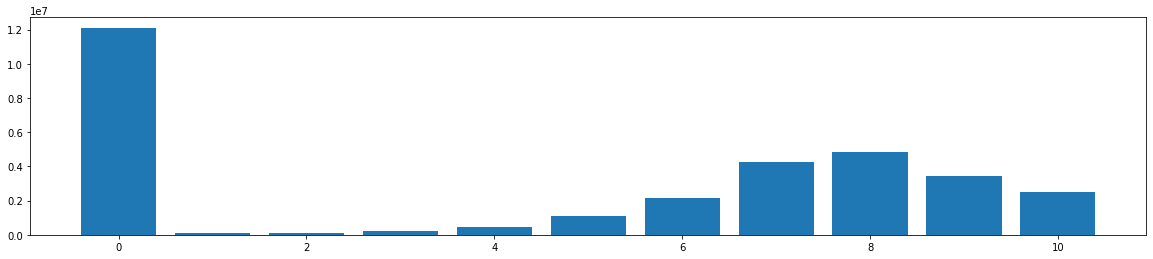

In [19]:
fig, ax = plt.subplots(figsize = (20,4))
ax.bar(ScoresDF_lite_with_names['my_score'].value_counts().index,
        ScoresDF_lite_with_names['my_score'].value_counts().values)


In [20]:
ScoresDF_lite_with_names[(ScoresDF_lite_with_names['title'] == "Detective Conan") & (ScoresDF_lite_with_names['my_score'] == 0)]


,username,anime_id,my_score,my_status,title
1935462,Slimak,235,0,1,Detective Conan
1935463,MistButterfly,235,0,3,Detective Conan
1935467,Sakurei,235,0,3,Detective Conan
1935469,ShinyShinigami,235,0,6,Detective Conan
1935482,ButterflyBoi,235,0,1,Detective Conan
...,...,...,...,...,...
1949716,HoneyToastAddict,235,0,1,Detective Conan
1949719,realFailix,235,0,4,Detective Conan
1949721,JuviaLockser,235,0,1,Detective Conan
1949722,Maiz94,235,0,1,Detective Conan


Score of 0 should not happen. MyAnimeList doesn't let to set the score to be 0 - the minimum is 1.

In [21]:
ScoresDF_lite_with_names_no_0_score = ScoresDF_lite_with_names[ScoresDF_lite_with_names['my_score'] > 0]
#scores_no_0_by_animeid = ScoresDF_lite_with_names_no_0_score.pivot_table(index='username', columns='title', values='my_score')
#anime_correlation_no_0 = scores_no_0_by_animeid.corr(method='pearson')
#anime_correlation_no_0.to_csv('pearson_model_no_zero.csv')

anime_correlation_no_0 = pd.read_csv('pearson_model_no_zero.csv')
anime_correlation_no_0


In [38]:
results_list_no_0 = anime_correlation_no_0["Nanatsu no Taizai"]
results_list_no_0

title
"Bungaku Shoujo" Kyou no Oyatsu: Hatsukoi       0.266479
"Bungaku Shoujo" Memoire                        0.319287
"Bungaku Shoujo" Movie                          0.316908
"Eikou Naki Tensai-tachi" Kara no Monogatari         NaN
"Eiyuu" Kaitai                                  0.536889
                                                  ...   
xxxHOLiC                                        0.234435
xxxHOLiC Kei                                    0.269854
xxxHOLiC Movie: Manatsu no Yoru no Yume         0.263795
xxxHOLiC Shunmuki                               0.281137
ēlDLIVE                                         0.428613
Name: Nanatsu no Taizai, Length: 6598, dtype: float64

In [39]:

results_dict_no_0 = results_list_no_0.to_dict()

# Sort by highest score
dict(sorted(results_dict_no_0.items(), key=lambda item: item[1], reverse=True))

{'"Eikou Naki Tensai-tachi" Kara no Monogatari': nan,
 '"Parade" de Satie': nan,
 'Clock Lock Works': 1.0,
 'Nyanpuku Nyaruma': 0.998625428903524,
 'Alphard x Taka no Tsume': 0.8660254037844387,
 'Akindo Sei no Little Peso': 0.8660254037844385,
 '3-Nen D-Gumi Glass no Kamen: Tobidase! Watashitachi no Victory Road': 0.846666610703511,
 'Lala-chan Santa no Fantasy Christmas': 0.8170571691028833,
 'Al Caral no Isan': 0.7207499701564469,
 'Anime Oyako Gekijou': 0.6885260370151464,
 'Cardfight!! Vanguard G: Z': 0.6539936878025849,
 '8-gatsu no Symphony: Shibuya 2002-2003': 0.6118791835531755,
 'Lady Lady!! (1988)': 0.5880847354817919,
 'Ancien to Mahou no Tablet: Mou Hitotsu no Hirune Hime': 0.5406116701371774,
 '"Eiyuu" Kaitai': 0.5368892771602283,
 'Cardfight!! Vanguard G: Next': 0.5320157097697383,
 'Amai Choubatsu: Watashi wa Kanshu Senyou Pet': 0.5277611626784793,
 '11eyes Picture Drama': 0.5023020961239004,
 'Akuma no Riddle: Shousha wa Dare? Nukiuchi Test': 0.4999973475386417,
 'Card